<a href="https://colab.research.google.com/github/flyark/AFM-LIS/blob/main/alphafold3_local_interaction_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Local Interaction Score analysis with AlphaFold3 output

*   **Preprint**: Enhanced Protein-Protein Interaction Discovery via AlphaFold-Multimer. Kim et al (2024) [link](https://www.biorxiv.org/content/10.1101/2024.02.19.580970v1)
*   **GitHub**: https://github.com/flyark/AFM-LIS
*   **FlyPredictome**: AlphaFold-Multimer database for large-scale *Drosophila* PPI preditions (>100K). [link](https://www.flyrnai.org/tools/fly_predictome/web/)
*   The current note is based on [alphafold3_lis_contact_v0.2.ipynb](https://github.com/flyark/AFM-LIS/blob/main/alphafold3_lis_contact_v0.2.ipynb)

*   Eventually you will hate this notebook due to slow analysis (uploading files and waiting for plotting etc).
*   Please consider installing **jupyter notebook** in your local computer.



## Description about output

- LIA: the number of PAE coordinates that are less than PAE cutoff **regardless of distance**.
- LIS: the average of inversely scaled PAE (0 to 1, high better) within LIA.
- LIR: the number of residues involved in the interactions in LIA.
- cLIA: the number of PAE coordinates that are less than PAE cutoff **within contact interface**.
- cLIS: the average of inversely scaled PAE (0 to 1, high better) within cLIA.
- cLIR: the nubmer of residues involved in the interactions in cLIA.
- iLIS: $\sqrt{\text{LIS} \times \text{cLIS}}$ **(Updated in v0.2)**.
- LIR_indices_A: the amino acid coordinates of protein_1 in LIA **(Updated in v0.2)**.
- LIR_indices_B: the amino acid coordinates of protein_2 in LIA **(Updated in v0.2)**.
- cLIR_indices_A: the amino acid coordinates of protein_1 in cLIA **(Updated in v0.2)**.
- cLIR_indices_B: the amino acid coordinates of protein_2 in cLIA **(Updated in v0.2)**.

## All results are averaged over two predictions.

For example, the result of protein 1 -> protein 2 and the result of protein 2 -> protein 1 are averaged.

## Acronyms

* LIA: Local Interaction Area
* LIS: Local Interaction Score
* LIR: Local Interaction Residue
* cLIA: contact Local Interaction Area
* cLIS: contact Local Interaction Score
* cLIR: contact Local Interaction Residue
* iLIS: integrated Local Interaction Score



# Installing and preparing LIS analysis

In [1]:
#@title Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# @title Loading libraries and function for LIS analysis
!pip install biopython
import os
import re
import json
import warnings
import numpy as np
import pandas as pd
from Bio.PDB import MMCIFParser
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import Counter
from scipy.spatial.distance import pdist, squareform

import matplotlib as mpl

warnings.filterwarnings('ignore')
np.seterr(divide='ignore', invalid='ignore')

import os
import re
import json
import warnings
import numpy as np
import pandas as pd
from Bio.PDB import MMCIFParser
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import Counter
from scipy.spatial.distance import pdist, squareform

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150 # change this for high resolution output

warnings.filterwarnings('ignore')
np.seterr(divide='ignore', invalid='ignore')

def transform_pae_matrix(pae_matrix, pae_cutoff):
    # Initialize the transformed matrix with zeros
    transformed_pae = np.zeros_like(pae_matrix)

    # Apply transformation: pae = 0 -> score = 1, pae = cutoff -> score = 0, above cutoff -> score = 0
    # Linearly scale values between 0 and cutoff to fall between 1 and 0
    within_cutoff = pae_matrix < pae_cutoff
    transformed_pae[within_cutoff] = 1 - (pae_matrix[within_cutoff] / pae_cutoff)

    return transformed_pae

def calculate_mean_lis(transformed_pae, subunit_number):
    # Calculate the cumulative sum of protein lengths to get the end indices of the submatrices
    cum_lengths = np.cumsum(subunit_number)

    # Add a zero at the beginning of the cumulative lengths to get the start indices
    start_indices = np.concatenate(([0], cum_lengths[:-1]))

    # Initialize an empty matrix to store the mean LIS
    mean_lis_matrix = np.zeros((len(subunit_number), len(subunit_number)))

    # Iterate over the start and end indices
    for i in range(len(subunit_number)):
        for j in range(len(subunit_number)):
            # Get the start and end indices of the interaction submatrix
            start_i, end_i = start_indices[i], cum_lengths[i]
            start_j, end_j = start_indices[j], cum_lengths[j]

            # Get the interaction submatrix
            submatrix = transformed_pae[start_i:end_i, start_j:end_j]

            # Calculate the mean LIS, considering only non-zero values
            mean_lis = submatrix[submatrix > 0].mean()

            # Store the mean LIS in the matrix
            mean_lis_matrix[i, j] = mean_lis

    return mean_lis_matrix

def calculate_contact_map(cif_file, distance_threshold=8):
    def read_cif_lines(cif_path):
        with open(cif_path, 'r') as file:
            lines = file.readlines()

        residue_lines = []
        for line in lines:
            if line.startswith('ATOM') and ('CB' in line or 'GLY' in line and 'CA' in line):
                residue_lines.append(line.strip())  # Store the line if it meets the criteria for ATOM

            if line.startswith('ATOM') and 'P   ' in line:
                residue_lines.append(line.strip()) # Store the line if it meets the criteria for ATOM

            elif line.startswith('HETATM'):
                residue_lines.append(line.strip())  # Store all HETATM lines

        return residue_lines

    def lines_to_dataframe(residue_lines):
        # Split lines and create a list of dictionaries for each atom
        data = []
        for line in residue_lines:
            parts = line.split()
            # Correctly convert numerical values
            for i in range(len(parts)):
                try:
                    parts[i] = float(parts[i])
                except ValueError:
                    pass
            data.append(parts)

        df = pd.DataFrame(data)

        # Add line number column
        df.insert(0, 'residue', range(1, 1 + len(df)))

        return df

    # Read lines from CIF file
    residue_lines = read_cif_lines(cif_file)

    # Convert lines to DataFrame
    df = lines_to_dataframe(residue_lines)

    # Assuming the columns for x, y, z coordinates are at indices 11, 12, 13 after insertion
    coordinates = df.iloc[:, 11:14].to_numpy()

    distances = squareform(pdist(coordinates))

    # Assuming the column for atom names is at index 3 after insertion
    has_phosphorus = df.iloc[:, 3].apply(lambda x: 'P' in str(x)).to_numpy()

    # Adjust the threshold for phosphorus-containing residues
    adjusted_distances = np.where(has_phosphorus[:, np.newaxis] | has_phosphorus[np.newaxis, :],
                                  distances - 4, distances)

    contact_map = np.where(adjusted_distances < distance_threshold, 1, 0)
    return contact_map


def afm3_plot(af3_json, pae_cutoff=12, distance_cutoff=8.0):
    model_number = re.search(r'full_data_(\d+)', af3_json).group(1)
    json_data = json.load(open(af3_json,'rb'))
    token_chain_ids = json_data['token_chain_ids']
    chain_residue_counts = Counter(token_chain_ids)
    subunit_number = list(chain_residue_counts.values())
    pae_matrix = np.array(json_data['pae'])
    pae_matrix = np.nan_to_num(pae_matrix)
    subunit_sizes = subunit_number
    boundaries = np.cumsum(subunit_sizes)[:-1]

    # Extract the base name of the JSON file (without extension)
    json_basename = os.path.splitext(os.path.basename(af3_json))[0]
    pdb_basename = json_basename.replace('_full_data_', '_model_')

    # Construct CIF file path based on JSON file path
    base_path = os.path.dirname(af3_json)
    cif_file = os.path.join(base_path, f'{pdb_basename}.cif')

    # --- Create the figure with 1 row and 6 columns ---
    fig, axs = plt.subplots(1, 6, figsize=(30, 6))

    # --------------------------------------------------------------------------------
    # (1) PAE Matrix (map)
    # --------------------------------------------------------------------------------
    cax1 = axs[0].matshow(pae_matrix, cmap='bwr', vmin=0, vmax=30)
    for boundary in boundaries:
        axs[0].axvline(x=boundary, color='black', lw=1, linestyle='-')
        axs[0].axhline(y=boundary, color='black', lw=1, linestyle='-')

    fig.colorbar(cax1, ax=axs[0], label='Predicted Aligned Error (PAE)', shrink=0.5)
    axs[0].set_title(f'Model {model_number} - PAE Map')
    axs[0].xaxis.tick_bottom()

    # --------------------------------------------------------------------------------
    # (2) Transformed PAE Matrix -> LIA map
    # --------------------------------------------------------------------------------
    transformed_pae_matrix = transform_pae_matrix(pae_matrix, pae_cutoff)
    transformed_pae_matrix = np.nan_to_num(transformed_pae_matrix)

    cax2 = axs[1].matshow(transformed_pae_matrix, cmap='Blues', vmin=0, vmax=1)
    for boundary in boundaries:
        axs[1].axvline(x=boundary, color='black', lw=1, linestyle='-')
        axs[1].axhline(y=boundary, color='black', lw=1, linestyle='-')

    fig.colorbar(cax2, ax=axs[1], label='Local Interaction Score (LIS)', shrink=0.5)
    axs[1].set_title(f'Model {model_number} - LIA Map')
    axs[1].xaxis.tick_bottom()

    # --------------------------------------------------------------------------------
    # (3) cLIA Map (combined PAE and contact)
    # --------------------------------------------------------------------------------
    contact_map = calculate_contact_map(cif_file, distance_cutoff)
    combined_map = np.where((transformed_pae_matrix > 0) & (contact_map == 1),
                            transformed_pae_matrix, 0)

    cax3 = axs[2].matshow(combined_map, cmap='Reds', vmin=0, vmax=1)
    for boundary in boundaries:
        axs[2].axvline(x=boundary, color='black', lw=1, linestyle='-')
        axs[2].axhline(y=boundary, color='black', lw=1, linestyle='-')

    fig.colorbar(cax3, ax=axs[2], label='Contact Local Interaction Score (cLIS)', shrink=0.5)
    axs[2].xaxis.tick_bottom()
    axs[2].set_title(f'Model {model_number} - cLIA Map')

    # --------------------------------------------------------------------------------
    # (4) LIS Heatmap
    # --------------------------------------------------------------------------------
    mean_lis_matrix = calculate_mean_lis(transformed_pae_matrix, subunit_sizes)
    mean_lis_matrix = np.nan_to_num(mean_lis_matrix)

    cax4 = axs[3].imshow(mean_lis_matrix, cmap='magma_r', interpolation='nearest', vmin=0, vmax=1)
    fig.colorbar(cax4, ax=axs[3], label='Local Interaction Score (LIS)', shrink=0.5)
    axs[3].set_title(f'Model {model_number} - LIS Heatmap')

    subunit_labels = [i for i in range(1, len(subunit_sizes)+1)]
    axs[3].set_xticks(np.arange(len(subunit_sizes)))
    axs[3].set_yticks(np.arange(len(subunit_sizes)))
    axs[3].set_xticklabels(subunit_labels)
    axs[3].set_yticklabels(subunit_labels)

    for i in range(len(subunit_sizes)):
        for j in range(len(subunit_sizes)):
            value = mean_lis_matrix[i, j]
            text_color = 'w' if value > 0.5 else 'k'
            axs[3].text(j, i, format(value, '.3f'), ha='center', va='center', color=text_color)

    # --------------------------------------------------------------------------------
    # (5) iLIS Heatmap = sqrt( LIS * cLIS )
    # --------------------------------------------------------------------------------
    mean_clis_matrix = calculate_mean_lis(combined_map, subunit_sizes)
    mean_clis_matrix = np.nan_to_num(mean_clis_matrix)

    ilis_matrix = np.sqrt(mean_lis_matrix * mean_clis_matrix)

    cax5 = axs[4].imshow(ilis_matrix, cmap='magma_r', interpolation='nearest', vmin=0, vmax=1)
    fig.colorbar(cax5, ax=axs[4], label='Integrated Local Interaction Score (iLIS)', shrink=0.5)
    axs[4].set_title(f'Model {model_number} - iLIS Heatmap')

    axs[4].set_xticks(np.arange(len(subunit_sizes)))
    axs[4].set_yticks(np.arange(len(subunit_sizes)))
    axs[4].set_xticklabels(subunit_labels)
    axs[4].set_yticklabels(subunit_labels)

    for i in range(len(subunit_sizes)):
        for j in range(len(subunit_sizes)):
            value = ilis_matrix[i, j]
            text_color = 'w' if value > 0.5 else 'k'
            axs[4].text(j, i, format(value, '.3f'), ha='center', va='center', color=text_color)

    # --------------------------------------------------------------------------------
    # (6) ipTM Heatmap
    # --------------------------------------------------------------------------------
    json_confidence = af3_json.replace('full_data', 'summary_confidences')
    with open(json_confidence, 'r') as file:
        confidence_data = json.load(file)

    iptm_matrix = np.array(confidence_data['chain_pair_iptm'], dtype=float)
    iptm_matrix = np.nan_to_num(iptm_matrix)

    cax6 = axs[5].imshow(iptm_matrix, cmap='Greens', vmin=0, vmax=1, interpolation='nearest')
    fig.colorbar(cax6, ax=axs[5], label='ipTM', shrink=0.5)
    axs[5].set_title(f'Model {model_number} - ipTM Heatmap')

    ticks = np.arange(1, iptm_matrix.shape[0] + 1)
    axs[5].set_xticks(ticks - 1)
    axs[5].set_yticks(ticks - 1)
    axs[5].set_xticklabels(ticks)
    axs[5].set_yticklabels(ticks)

    for i in range(iptm_matrix.shape[0]):
        for j in range(iptm_matrix.shape[1]):
            value = iptm_matrix[i, j]
            text_color = 'w' if value > 0.7 else 'k'
            axs[5].text(j, i, format(value, '.3f'), ha='center', va='center', color=text_color)

    plt.tight_layout()
    plt.show()

def load_and_plot_heatmap(json_file):
    # Step 1: Load JSON file
    with open(json_file, 'r') as file:
        data = json.load(file)

    # Step 2: Extract IPTM matrix
    iptm_matrix = data['chain_pair_iptm']

    # Step 3: Convert None to np.nan (or any other value you prefer)
    iptm_matrix = np.array(iptm_matrix, dtype=float)  # Converts None to np.nan automatically

    # Step 4: Create heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(iptm_matrix, cmap='viridis', vmin = 0, vmax = 1, interpolation='nearest')
    plt.colorbar(label='ipTM')
    plt.title('Heatmap of IPTM')
    plt.show()

def generate_json_paths(base_path, number_of_models=5):
    """
    Generates a list of JSON file paths for a given number of models within a specified base path.

    Parameters:
    - base_path (str): The base directory where the model JSON files are stored.
    - number_of_models (int): The number of model JSON files to generate paths for.

    Returns:
    - list: A list of fully qualified paths to the JSON files.
    """
    model_identifier = os.path.basename(base_path)
    json_files = [f"{base_path}/{model_identifier}_full_data_{model}.json" for model in range(number_of_models)]
    return json_files

def afm3_plot_average(af3_jsons, pae_cutoff=12, distance_cutoff=8):
    # Initialize the sum of PAE matrices, transformed PAE matrices, mean LIS, contact LIS, and ipTM
    sum_pae_matrix = None
    sum_transformed_pae_matrix = None
    sum_mean_lis_matrix = None
    sum_contact_lia_map = None
    sum_iptm_matrix = None

    # -------------------------- Loop over each model -------------------------------
    for af3_json in af3_jsons:
        json_data = json.load(open(af3_json,'rb'))
        json_confidence = af3_json.replace('full_data', 'summary_confidences')
        confidence_data = json.load(open(json_confidence, 'rb'))

        token_chain_ids = json_data['token_chain_ids']
        chain_residue_counts = Counter(token_chain_ids)
        subunit_number = list(chain_residue_counts.values())
        pae_matrix = np.array(json_data['pae'])
        subunit_sizes = subunit_number

        cif_file = af3_json.replace('_full_data_', '_model_').replace('.json', '.cif')

        # Transform the PAE matrix to LIS
        transformed_pae_matrix = transform_pae_matrix(pae_matrix, pae_cutoff)
        transformed_pae_matrix = np.nan_to_num(transformed_pae_matrix)

        # Mean LIS matrix
        mean_lis_matrix = calculate_mean_lis(transformed_pae_matrix, subunit_sizes)
        mean_lis_matrix = np.nan_to_num(mean_lis_matrix)

        # Contact map & combined map => cLIS
        contact_map = calculate_contact_map(cif_file, distance_cutoff)
        combined_map = np.where((transformed_pae_matrix > 0) & (contact_map == 1), transformed_pae_matrix, 0)

        # ipTM
        iptm_matrix = np.array(confidence_data['chain_pair_iptm'], dtype=float)
        iptm_matrix = np.nan_to_num(iptm_matrix)

        # Accumulate sums for averaging
        if sum_pae_matrix is None:
            sum_pae_matrix = pae_matrix
            sum_transformed_pae_matrix = transformed_pae_matrix
            sum_mean_lis_matrix = mean_lis_matrix
            sum_contact_lia_map = combined_map
            sum_iptm_matrix = iptm_matrix
        else:
            sum_pae_matrix += pae_matrix
            sum_transformed_pae_matrix += transformed_pae_matrix
            sum_mean_lis_matrix += mean_lis_matrix
            sum_contact_lia_map += combined_map
            sum_iptm_matrix += iptm_matrix

    # -------------------------- Calculate the Average -------------------------------
    n = len(af3_jsons)

    avg_pae_matrix = sum_pae_matrix / n
    avg_transformed_pae_matrix = sum_transformed_pae_matrix / n
    avg_mean_lis_matrix = sum_mean_lis_matrix / n
    avg_contact_lia_map = sum_contact_lia_map / n
    avg_iptm_matrix = sum_iptm_matrix / n

    # Replace nan with 0
    avg_pae_matrix = np.nan_to_num(avg_pae_matrix)
    avg_transformed_pae_matrix = np.nan_to_num(avg_transformed_pae_matrix)
    avg_mean_lis_matrix = np.nan_to_num(avg_mean_lis_matrix)
    avg_contact_lia_map = np.nan_to_num(avg_contact_lia_map)
    avg_iptm_matrix = np.nan_to_num(avg_iptm_matrix)

    # -------------------------- Create the figure -----------------------------------
    fig, axs = plt.subplots(1, 6, figsize=(30, 5))

    # Boundaries for subunits
    boundaries = np.cumsum(subunit_sizes)[:-1]
    subunit_labels = [i for i in range(1, len(subunit_sizes)+1)]

    # --------------------------------------------------------------------------------
    # (1) Average PAE map
    # --------------------------------------------------------------------------------
    cax1 = axs[0].matshow(avg_pae_matrix, cmap='bwr', vmin=0, vmax=30)
    fig.colorbar(cax1, ax=axs[0], label='Average PAE', shrink=0.5)
    axs[0].set_title('Avg PAE Map')
    axs[0].xaxis.tick_bottom()

    for boundary in boundaries:
        axs[0].axvline(x=boundary, color='black', lw=1, linestyle='-')
        axs[0].axhline(y=boundary, color='black', lw=1, linestyle='-')

    # --------------------------------------------------------------------------------
    # (2) Average LIA map
    # --------------------------------------------------------------------------------
    cax2 = axs[1].matshow(avg_transformed_pae_matrix, cmap='Blues', vmin=0, vmax=1)
    fig.colorbar(cax2, ax=axs[1], label='Average LIS', shrink=0.5)
    axs[1].set_title('Avg LIA Map')
    axs[1].xaxis.tick_bottom()

    for boundary in boundaries:
        axs[1].axvline(x=boundary, color='black', lw=1, linestyle='-')
        axs[1].axhline(y=boundary, color='black', lw=1, linestyle='-')

    # --------------------------------------------------------------------------------
    # (3) Average cLIA map
    # --------------------------------------------------------------------------------
    cax3 = axs[2].matshow(avg_contact_lia_map, cmap='Reds', vmin=0, vmax=1)
    fig.colorbar(cax3, ax=axs[2], label='Average cLIS', shrink=0.5)
    axs[2].set_title('Avg cLIA Map')
    axs[2].xaxis.tick_bottom()

    for boundary in boundaries:
        axs[2].axvline(x=boundary, color='black', lw=1, linestyle='-')
        axs[2].axhline(y=boundary, color='black', lw=1, linestyle='-')

    # --------------------------------------------------------------------------------
    # (4) Average LIS Heatmap
    # --------------------------------------------------------------------------------
    cax4 = axs[3].imshow(avg_mean_lis_matrix, cmap='magma_r', interpolation='nearest', vmin=0, vmax=1)
    fig.colorbar(cax4, ax=axs[3], label='Avg LIS', shrink=0.5)
    axs[3].set_title('Avg LIS Heatmap')

    axs[3].set_xticks(np.arange(len(subunit_sizes)))
    axs[3].set_yticks(np.arange(len(subunit_sizes)))
    axs[3].set_xticklabels(subunit_labels)
    axs[3].set_yticklabels(subunit_labels)

    for i in range(len(subunit_sizes)):
        for j in range(len(subunit_sizes)):
            value = avg_mean_lis_matrix[i, j]
            text_color = 'w' if value > 0.5 else 'k'
            axs[3].text(j, i, f"{value:.3f}", ha='center', va='center', color=text_color)

    # --------------------------------------------------------------------------------
    # (5) Average iLIS Heatmap (iLIS = sqrt(LIS * cLIS))
    # --------------------------------------------------------------------------------
    mean_clis_matrix = calculate_mean_lis(avg_contact_lia_map, subunit_sizes)
    mean_clis_matrix = np.nan_to_num(mean_clis_matrix)

    ilis_matrix = np.sqrt(avg_mean_lis_matrix * mean_clis_matrix)

    cax5 = axs[4].imshow(ilis_matrix, cmap='magma_r', interpolation='nearest', vmin=0, vmax=1)
    fig.colorbar(cax5, ax=axs[4], label='Avg iLIS', shrink=0.5)
    axs[4].set_title('Avg iLIS Heatmap')

    axs[4].set_xticks(np.arange(len(subunit_sizes)))
    axs[4].set_yticks(np.arange(len(subunit_sizes)))
    axs[4].set_xticklabels(subunit_labels)
    axs[4].set_yticklabels(subunit_labels)

    for i in range(len(subunit_sizes)):
        for j in range(len(subunit_sizes)):
            value = ilis_matrix[i, j]
            text_color = 'w' if value > 0.5 else 'k'
            axs[4].text(j, i, f"{value:.3f}", ha='center', va='center', color=text_color)

    # --------------------------------------------------------------------------------
    # (6) Average ipTM Heatmap
    # --------------------------------------------------------------------------------
    cax6 = axs[5].imshow(avg_iptm_matrix, cmap='Greens', vmin=0, vmax=1, interpolation='nearest')
    fig.colorbar(cax6, ax=axs[5], label='Avg ipTM', shrink=0.5)
    axs[5].set_title('Avg ipTM Heatmap')

    ticks = np.arange(1, avg_iptm_matrix.shape[0] + 1)
    axs[5].set_xticks(ticks - 1)
    axs[5].set_yticks(ticks - 1)
    axs[5].set_xticklabels(ticks)
    axs[5].set_yticklabels(ticks)

    for i in range(avg_iptm_matrix.shape[0]):
        for j in range(avg_iptm_matrix.shape[1]):
            value = avg_iptm_matrix[i, j]
            if np.isnan(value):
                continue
            text_color = 'w' if value > 0.7 else 'k'
            axs[5].text(j, i, f"{value:.3f}", ha='center', va='center', color=text_color)

    plt.tight_layout()
    plt.show()

def afm3_plot_average_to_df(af3_jsons, pae_cutoff=12, distance_cutoff=8, result_save = "True"):
    sum_pae_matrix = None
    sum_transformed_pae_matrix = None
    sum_mean_lis_matrix = None
    sum_contact_lia_map = None
    sum_iptm_matrix = None
    all_interactions = []

    for af3_json in af3_jsons:
        json_data = json.load(open(af3_json, 'rb'))
        json_confidence = af3_json.replace('full_data', 'summary_confidences')
        confidence_data = json.load(open(json_confidence, 'rb'))

        token_chain_ids = json_data['token_chain_ids']
        chain_residue_counts = Counter(token_chain_ids)
        subunit_number = list(chain_residue_counts.values())
        pae_matrix = np.array(json_data['pae'])
        subunit_sizes = subunit_number

        cif_file = af3_json.replace('_full_data_', '_model_').replace('.json', '.cif')

        transformed_pae_matrix = transform_pae_matrix(pae_matrix, pae_cutoff)
        transformed_pae_matrix = np.nan_to_num(transformed_pae_matrix)
        lia_map = np.where(transformed_pae_matrix > 0, 1, 0)

        mean_lis_matrix = calculate_mean_lis(transformed_pae_matrix, subunit_sizes)
        mean_lis_matrix = np.nan_to_num(mean_lis_matrix)

        contact_map = calculate_contact_map(cif_file, distance_cutoff)
        combined_map = np.where((transformed_pae_matrix > 0) & (contact_map == 1), transformed_pae_matrix, 0)
        mean_clis_matrix = calculate_mean_lis(combined_map, subunit_sizes)
        mean_clis_matrix = np.nan_to_num(mean_clis_matrix)

        # Count-based metrics: LIA, LIR, cLIA, cLIR
        lia_matrix = np.zeros((len(subunit_sizes), len(subunit_sizes)))
        lir_matrix = np.zeros((len(subunit_sizes), len(subunit_sizes)))
        clia_matrix = np.zeros((len(subunit_sizes), len(subunit_sizes)))
        clir_matrix = np.zeros((len(subunit_sizes), len(subunit_sizes)))

        for i in range(len(subunit_sizes)):
            for j in range(len(subunit_sizes)):
                start_i, end_i = sum(subunit_sizes[:i]), sum(subunit_sizes[:i+1])
                start_j, end_j = sum(subunit_sizes[:j]), sum(subunit_sizes[:j+1])
                interaction_submatrix = lia_map[start_i:end_i, start_j:end_j]

                # LIA
                lia_matrix[i, j] = int(np.count_nonzero(interaction_submatrix))
                residues_i = np.unique(np.where(interaction_submatrix > 0)[0]) + start_i
                residues_j = np.unique(np.where(interaction_submatrix > 0)[1]) + start_j
                lir_matrix[i, j] = int(len(residues_i) + len(residues_j))

                # cLIA
                combined_submatrix = combined_map[start_i:end_i, start_j:end_j]
                clia_matrix[i, j] = int(np.count_nonzero(combined_submatrix))
                residues_i = np.unique(np.where(combined_submatrix > 0)[0]) + start_i
                residues_j = np.unique(np.where(combined_submatrix > 0)[1]) + start_j
                clir_matrix[i, j] = int(len(residues_i) + len(residues_j))

        # ipTM
        iptm_matrix = confidence_data['chain_pair_iptm']
        iptm_matrix = np.array(iptm_matrix, dtype=float)
        iptm_matrix = np.nan_to_num(iptm_matrix)

        # Accumulate sums for averaging
        if sum_pae_matrix is None:
            sum_pae_matrix = pae_matrix
            sum_transformed_pae_matrix = transformed_pae_matrix
            sum_mean_lis_matrix = mean_lis_matrix
            sum_contact_lia_map = combined_map
            sum_iptm_matrix = iptm_matrix
        else:
            sum_pae_matrix += pae_matrix
            sum_transformed_pae_matrix += transformed_pae_matrix
            sum_mean_lis_matrix += mean_lis_matrix
            sum_contact_lia_map += combined_map
            sum_iptm_matrix += iptm_matrix

        # Create rows for this model
        model_number = re.search(r'full_data_(\d+)', af3_json).group(1)
        folder_name = os.path.basename(os.path.dirname(af3_json))
        for i in range(len(subunit_sizes)):
            for j in range(len(subunit_sizes)):
                # Add iLIS = sqrt(LIS * cLIS)
                iLIS_value = np.sqrt(mean_lis_matrix[i, j] * mean_clis_matrix[i, j])
                interaction = {
                    'folder_name': folder_name,
                    'model_number': model_number,
                    'protein_1': i + 1,
                    'protein_2': j + 1,
                    'iLIS': iLIS_value,
                    'LIS': mean_lis_matrix[i, j],
                    'LIA': lia_matrix[i, j],
                    'LIR': lir_matrix[i, j],
                    'cLIS': mean_clis_matrix[i, j],
                    'cLIA': clia_matrix[i, j],
                    'cLIR': clir_matrix[i, j],
                    'iptm': iptm_matrix[i, j],
                }
                all_interactions.append(interaction)

    # Create average matrices (not strictly necessary for DF, but done for completeness)
    avg_pae_matrix = sum_pae_matrix / len(af3_jsons)
    avg_transformed_pae_matrix = sum_transformed_pae_matrix / len(af3_jsons)
    avg_mean_lis_matrix = sum_mean_lis_matrix / len(af3_jsons)
    avg_contact_lia_map = sum_contact_lia_map / len(af3_jsons)
    avg_iptm_matrix = sum_iptm_matrix / len(af3_jsons)

    # Replace nan with 0
    avg_pae_matrix = np.nan_to_num(avg_pae_matrix)
    avg_transformed_pae_matrix = np.nan_to_num(avg_transformed_pae_matrix)
    avg_mean_lis_matrix = np.nan_to_num(avg_mean_lis_matrix)
    avg_iptm_matrix = np.nan_to_num(avg_iptm_matrix)

    # Build final DataFrame
    df_interactions = pd.DataFrame(all_interactions)
    # Sort the chain pair into a tuple so (1,2) and (2,1) are the same
    df_interactions['interaction'] = df_interactions.apply(
        lambda row: tuple(sorted((row['protein_1'], row['protein_2']))), axis=1
    )
    # Group by (folder_name, model_number, interaction) to get a single row per pair per model
    df_merged = df_interactions.groupby(['folder_name', 'model_number', 'interaction']).mean().reset_index()
    df_merged[['protein_1', 'protein_2']] = pd.DataFrame(df_merged['interaction'].tolist(), index=df_merged.index)
    df_merged = df_merged.drop(columns=['interaction'])

    # Calculate average values for each protein pair across all models, add as new rows
    avg_rows = []
    interaction_pairs = df_merged.groupby(['protein_1', 'protein_2'])

    for (protein_1, protein_2), group in interaction_pairs:
        avg_row = {
            'folder_name': folder_name,
            'model_number': 'average',
            'protein_1': protein_1,
            'protein_2': protein_2,
            'iLIS': group['iLIS'].mean(),
            'LIS': group['LIS'].mean(),
            'LIA': group['LIA'].mean(),
            'LIR': group['LIR'].mean(),
            'cLIS': group['cLIS'].mean(),
            'cLIA': group['cLIA'].mean(),
            'cLIR': group['cLIR'].mean(),
            'iptm': group['iptm'].mean(),
        }
        avg_rows.append(avg_row)

    df_avg = pd.DataFrame(avg_rows)
    df_merged = pd.concat([df_merged, df_avg], ignore_index=True)

    # Convert these to integer for clarity
    df_merged['LIA'] = df_merged['LIA'].astype(int)
    df_merged['LIR'] = df_merged['LIR'].astype(int)
    df_merged['cLIA'] = df_merged['cLIA'].astype(int)
    df_merged['cLIR'] = df_merged['cLIR'].astype(int)

    # Save DataFrame to CSV
    output_folder = os.path.dirname(af3_jsons[0])
    output_path = os.path.join(output_folder, f"{folder_name}_lis_analysis.csv")
    if result_save == "True":
        df_merged.to_csv(output_path, index=False)
        print("Results saved to: ", output_path)
        print(f"{folder_name}_lis_analysis.csv")

    return df_merged

def afm3_plot_average_to_df(af3_jsons, pae_cutoff=12, distance_cutoff=8, result_save="True"):
    sum_pae_matrix = None
    sum_transformed_pae_matrix = None
    sum_mean_lis_matrix = None
    sum_contact_lia_map = None
    sum_iptm_matrix = None
    all_interactions = []

    for af3_json in af3_jsons:
        # ----------------------------------------------
        # 1) Read JSON data
        # ----------------------------------------------
        json_data = json.load(open(af3_json, 'rb'))
        json_confidence = af3_json.replace('full_data', 'summary_confidences')
        confidence_data = json.load(open(json_confidence, 'rb'))

        token_chain_ids = json_data['token_chain_ids']
        chain_residue_counts = Counter(token_chain_ids)
        subunit_number = list(chain_residue_counts.values())
        pae_matrix = np.array(json_data['pae'], dtype=float)
        pae_matrix = np.nan_to_num(pae_matrix)

        # ----------------------------------------------
        # 2) Transform PAE matrix => LIS
        # ----------------------------------------------
        transformed_pae_matrix = transform_pae_matrix(pae_matrix, pae_cutoff)
        transformed_pae_matrix = np.nan_to_num(transformed_pae_matrix)

        # A binary map (1 where LIS>0, else 0)
        lia_map = np.where(transformed_pae_matrix > 0, 1, 0)

        mean_lis_matrix = calculate_mean_lis(transformed_pae_matrix, subunit_number)
        mean_lis_matrix = np.nan_to_num(mean_lis_matrix)

        # ----------------------------------------------
        # 3) Contact map => cLIA
        # ----------------------------------------------
        cif_file = af3_json.replace('_full_data_', '_model_').replace('.json', '.cif')
        contact_map = calculate_contact_map(cif_file, distance_cutoff)

        combined_map = np.where(
            (transformed_pae_matrix > 0) & (contact_map == 1),
            transformed_pae_matrix,
            0
        )
        mean_clis_matrix = calculate_mean_lis(combined_map, subunit_number)
        mean_clis_matrix = np.nan_to_num(mean_clis_matrix)

        # ----------------------------------------------
        # 4) Count-based metrics: LIA, LIR, cLIA, cLIR
        #    plus local (per-subunit) residue indices
        # ----------------------------------------------
        subunit_count = len(subunit_number)
        lia_matrix = np.zeros((subunit_count, subunit_count), dtype=int)
        lir_matrix = np.zeros((subunit_count, subunit_count), dtype=int)
        clia_matrix = np.zeros((subunit_count, subunit_count), dtype=int)
        clir_matrix = np.zeros((subunit_count, subunit_count), dtype=int)

        # For extracting submatrices
        cum_lengths = np.cumsum(subunit_number)
        starts = np.concatenate(([0], cum_lengths[:-1]))

        for i in range(subunit_count):
            for j in range(subunit_count):
                # subunit i spans [start_i, end_i), subunit j spans [start_j, end_j)
                start_i, end_i = starts[i], cum_lengths[i]
                start_j, end_j = starts[j], cum_lengths[j]

                # Submatrix for LIS-based local interactions (binary)
                interaction_submatrix = lia_map[start_i:end_i, start_j:end_j]
                lia_matrix[i, j] = np.count_nonzero(interaction_submatrix)

                # *Local* residue indices for subunit i and j => add +1 to be 1-based
                # but do NOT add +start_i or +start_j, so each subunit is 1..(subunit_number[i])
                residues_i_LIR = np.unique(np.where(interaction_submatrix > 0)[0]) + 1
                residues_j_LIR = np.unique(np.where(interaction_submatrix > 0)[1]) + 1
                lir_matrix[i, j] = len(residues_i_LIR) + len(residues_j_LIR)

                # Submatrix for contact-based local interactions
                combined_submatrix = combined_map[start_i:end_i, start_j:end_j]
                clia_matrix[i, j] = np.count_nonzero(combined_submatrix)

                residues_i_cLIR = np.unique(np.where(combined_submatrix > 0)[0]) + 1
                residues_j_cLIR = np.unique(np.where(combined_submatrix > 0)[1]) + 1
                clir_matrix[i, j] = len(residues_i_cLIR) + len(residues_j_cLIR)

        # ----------------------------------------------
        # 5) ipTM
        # ----------------------------------------------
        iptm_matrix = np.array(confidence_data['chain_pair_iptm'], dtype=float)
        iptm_matrix = np.nan_to_num(iptm_matrix)

        # ----------------------------------------------
        # 6) Accumulate sums for averaging across models
        # ----------------------------------------------
        if sum_pae_matrix is None:
            sum_pae_matrix = pae_matrix
            sum_transformed_pae_matrix = transformed_pae_matrix
            sum_mean_lis_matrix = mean_lis_matrix
            sum_contact_lia_map = combined_map
            sum_iptm_matrix = iptm_matrix
        else:
            sum_pae_matrix += pae_matrix
            sum_transformed_pae_matrix += transformed_pae_matrix
            sum_mean_lis_matrix += mean_lis_matrix
            sum_contact_lia_map += combined_map
            sum_iptm_matrix += iptm_matrix

        # ----------------------------------------------
        # 7) Build model-level rows
        #    with the local (per-subunit) indices
        # ----------------------------------------------
        model_number = re.search(r'full_data_(\d+)', af3_json).group(1)
        folder_name = os.path.basename(os.path.dirname(af3_json))

        for i in range(subunit_count):
            for j in range(subunit_count):
                iLIS_value = np.sqrt(mean_lis_matrix[i, j] * mean_clis_matrix[i, j])

                # We re-derive the local submatrices to get the final index arrays
                start_i, end_i = starts[i], cum_lengths[i]
                start_j, end_j = starts[j], cum_lengths[j]

                interaction_submatrix = lia_map[start_i:end_i, start_j:end_j]
                residues_i_LIR = np.unique(np.where(interaction_submatrix > 0)[0]) + 1
                residues_j_LIR = np.unique(np.where(interaction_submatrix > 0)[1]) + 1

                combined_submatrix = combined_map[start_i:end_i, start_j:end_j]
                residues_i_cLIR = np.unique(np.where(combined_submatrix > 0)[0]) + 1
                residues_j_cLIR = np.unique(np.where(combined_submatrix > 0)[1]) + 1

                row_dict = {
                    'folder_name': folder_name,
                    'model_number': model_number,
                    'protein_1': i + 1,
                    'protein_2': j + 1,
                    'iLIS': iLIS_value,
                    'LIS': mean_lis_matrix[i, j],
                    'LIA': lia_matrix[i, j],
                    'LIR': lir_matrix[i, j],
                    'cLIS': mean_clis_matrix[i, j],
                    'cLIA': clia_matrix[i, j],
                    'cLIR': clir_matrix[i, j],
                    'iptm': iptm_matrix[i, j],
                    'LIR_indices_A': residues_i_LIR.tolist(),
                    'LIR_indices_B': residues_j_LIR.tolist(),
                    'cLIR_indices_A': residues_i_cLIR.tolist(),
                    'cLIR_indices_B': residues_j_cLIR.tolist()
                }
                all_interactions.append(row_dict)

    # -----------------------------------------------------------
    # 8) Create average matrices (optional but consistent)
    # -----------------------------------------------------------
    n = len(af3_jsons)
    avg_pae_matrix = np.nan_to_num(sum_pae_matrix / n)
    avg_transformed_pae_matrix = np.nan_to_num(sum_transformed_pae_matrix / n)
    avg_mean_lis_matrix = np.nan_to_num(sum_mean_lis_matrix / n)
    avg_contact_lia_map = np.nan_to_num(sum_contact_lia_map / n)
    avg_iptm_matrix = np.nan_to_num(sum_iptm_matrix / n)

    # -----------------------------------------------------------
    # 9) Build final DataFrame, group, reorder columns
    # -----------------------------------------------------------
    df_interactions = pd.DataFrame(all_interactions)

    # Sort the chain pair into a tuple so (1,2) and (2,1) are recognized as the same
    df_interactions['interaction'] = df_interactions.apply(
        lambda row: tuple(sorted((row['protein_1'], row['protein_2']))),
        axis=1
    )

    # Use an explicit aggregator to keep columns properly
    df_merged = df_interactions.groupby(
        ['folder_name', 'model_number', 'interaction'], as_index=False
    ).agg({
        'protein_1': 'first',
        'protein_2': 'first',
        'iLIS': 'mean',
        'LIS': 'mean',
        'LIA': 'mean',
        'LIR': 'mean',
        'cLIS': 'mean',
        'cLIA': 'mean',
        'cLIR': 'mean',
        'iptm': 'mean',
        'LIR_indices_A': 'first',
        'LIR_indices_B': 'first',
        'cLIR_indices_A': 'first',
        'cLIR_indices_B': 'first'
    })

    # Now add "average" rows, per (protein_1, protein_2) across all models
    avg_rows = []
    for (p1, p2), sub_df in df_merged.groupby(['protein_1', 'protein_2']):
        first_row = sub_df.iloc[0]
        avg_rows.append({
            'folder_name': first_row['folder_name'],
            'model_number': 'average',
            'interaction': (p1, p2),
            'protein_1': p1,
            'protein_2': p2,
            'iLIS': sub_df['iLIS'].mean(),
            'LIS': sub_df['LIS'].mean(),
            'LIA': sub_df['LIA'].mean(),
            'LIR': sub_df['LIR'].mean(),
            'cLIS': sub_df['cLIS'].mean(),
            'cLIA': sub_df['cLIA'].mean(),
            'cLIR': sub_df['cLIR'].mean(),
            'iptm': sub_df['iptm'].mean(),
            'LIR_indices_A': None,
            'LIR_indices_B': None,
            'cLIR_indices_A': None,
            'cLIR_indices_B': None
        })

    df_avg = pd.DataFrame(avg_rows)
    df_merged = pd.concat([df_merged, df_avg], ignore_index=True)

    # Convert selected columns to integer
    for col in ['LIA', 'LIR', 'cLIA', 'cLIR']:
        df_merged[col] = df_merged[col].astype(int)

    # We can now drop 'interaction' if we like
    if 'interaction' in df_merged.columns:
        df_merged.drop(columns=['interaction'], inplace=True)

    # Reorder columns so folder_name, model_number are first
    desired_order = [
        'folder_name', 'model_number',
        'protein_1', 'protein_2',
        'iLIS', 'LIS', 'LIA', 'LIR',
        'cLIS', 'cLIA', 'cLIR',
        'iptm',
        'LIR_indices_A', 'LIR_indices_B',
        'cLIR_indices_A', 'cLIR_indices_B'
    ]
    df_merged = df_merged[desired_order]

    # -----------------------------------------------------------
    # 10) Save DataFrame to CSV
    # -----------------------------------------------------------
    output_folder = os.path.dirname(af3_jsons[0])
    folder_name = os.path.basename(output_folder)
    output_path = os.path.join(output_folder, f"{folder_name}_lis_analysis.csv")

    if result_save == "True":
        df_merged.to_csv(output_path, index=False)
        print("Results saved to:", output_path)
        print(f"{folder_name}_lis_analysis.csv")

    return df_merged



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 22.4 MB/s eta 0:00:00


# Uploading AF3 output to Google Drive

In [3]:
#@title Find AF3 output and upload AF3 **zip** file


from google.colab import files
import os
import shutil
import zipfile

# Step 1: Upload the File
uploaded = files.upload()

# Step 2: Create the target directory if it doesn't exist
target_directory_base = '/content/alphafold3'
os.makedirs(target_directory_base, exist_ok=True)

# Step 3: Move the uploaded file to the base target directory
for filename in uploaded.keys():
    shutil.move(filename, os.path.join(target_directory_base, filename))

# Initialize the base_path variable
base_path = None

# Step 4: Unzip the file into a new directory named after the zip file (without .zip extension)
for filename in uploaded.keys():
    if filename.endswith('.zip'):
        # Create a directory named after the zip file (without .zip extension)
        extract_directory = os.path.join(target_directory_base, filename[:-4])
        os.makedirs(extract_directory, exist_ok=True)

        # Unzip the file into the new directory
        with zipfile.ZipFile(os.path.join(target_directory_base, filename), 'r') as zip_ref:
            zip_ref.extractall(extract_directory)

        # Set base_path to the directory containing the unzipped files
        base_path = extract_directory

# Step 5: List files in the base target directory and the newly created directory
print(f"Unzipped files in '{base_path}':")



Saving fold_chi_ap_afm3.zip to fold_chi_ap_afm3.zip
Unzipped files in '/content/alphafold3/fold_chi_ap_afm3':


# Proceed the below cell by Shift+Enter


*   Individual plots can be downloaded by righ+mouse click
*   LIS output csv file is saved in individual af3 output folder in '/content/alphafold3'



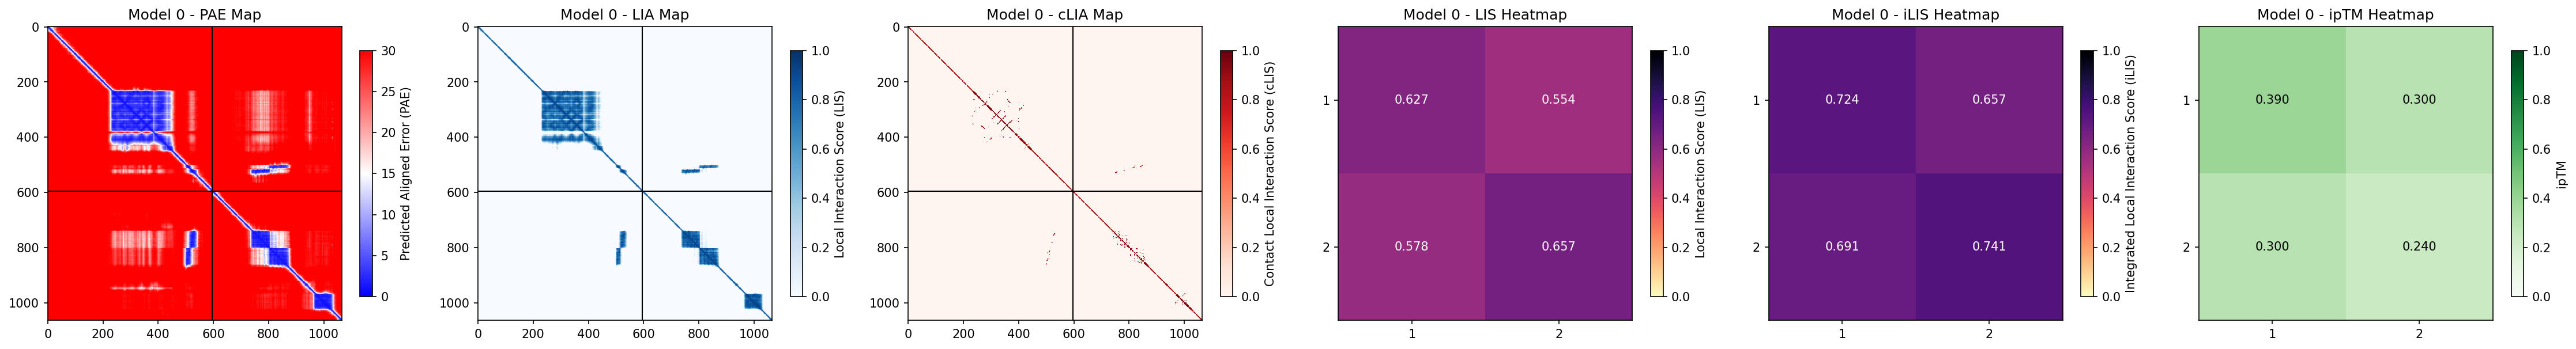

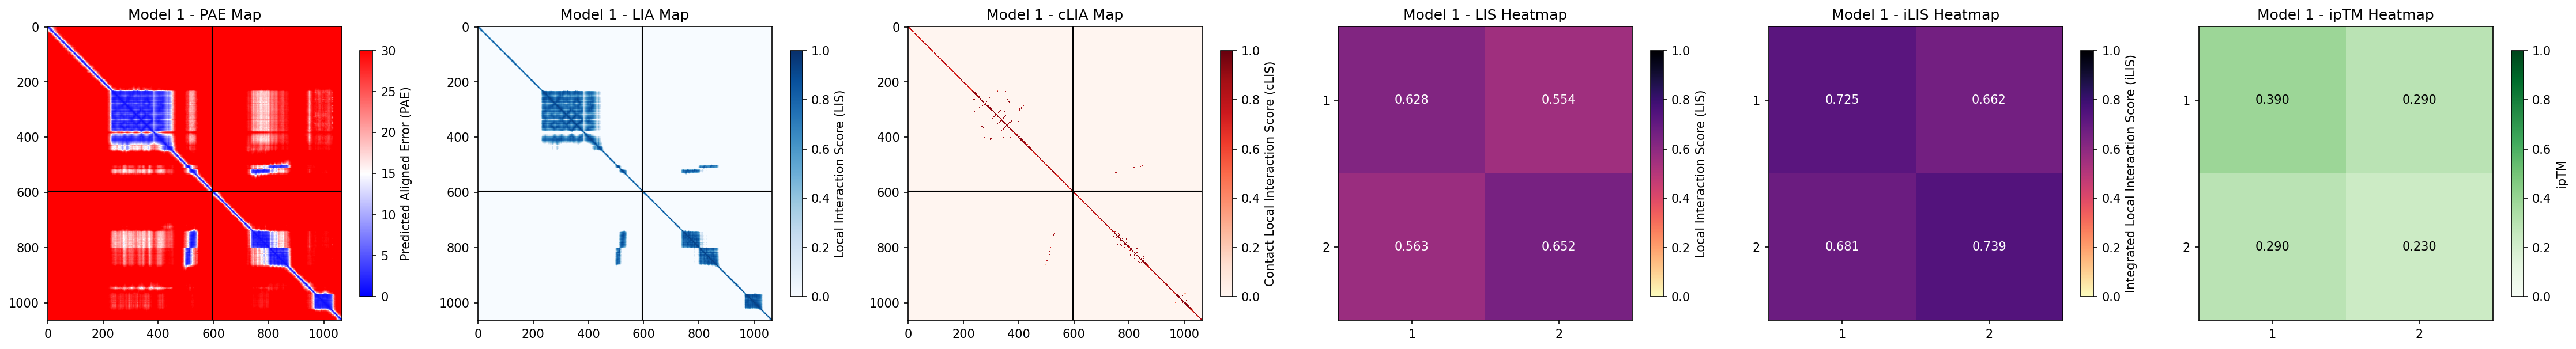

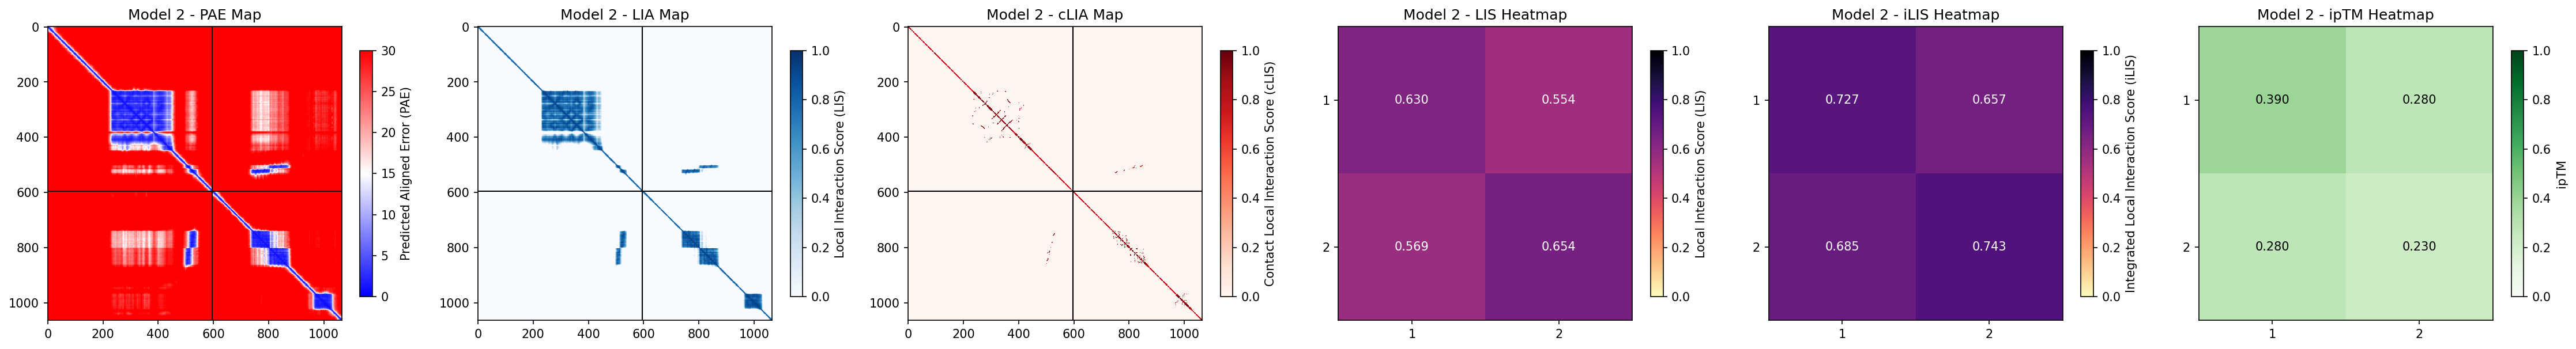

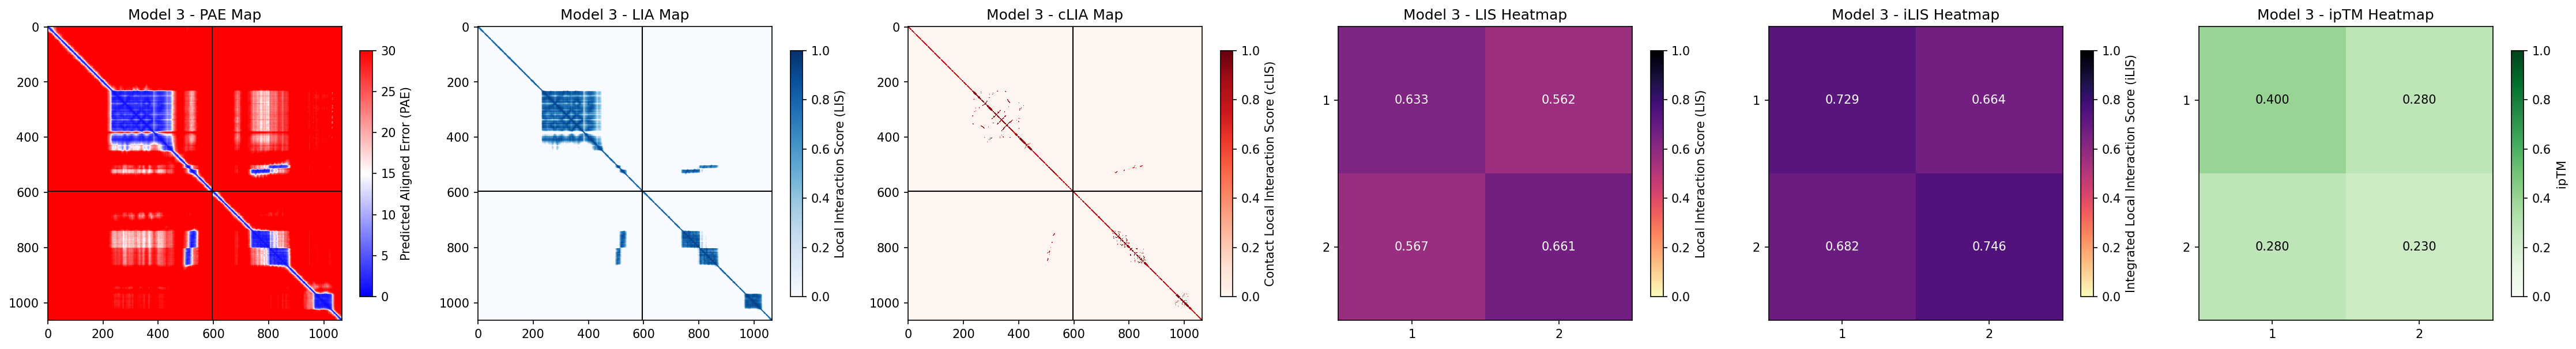

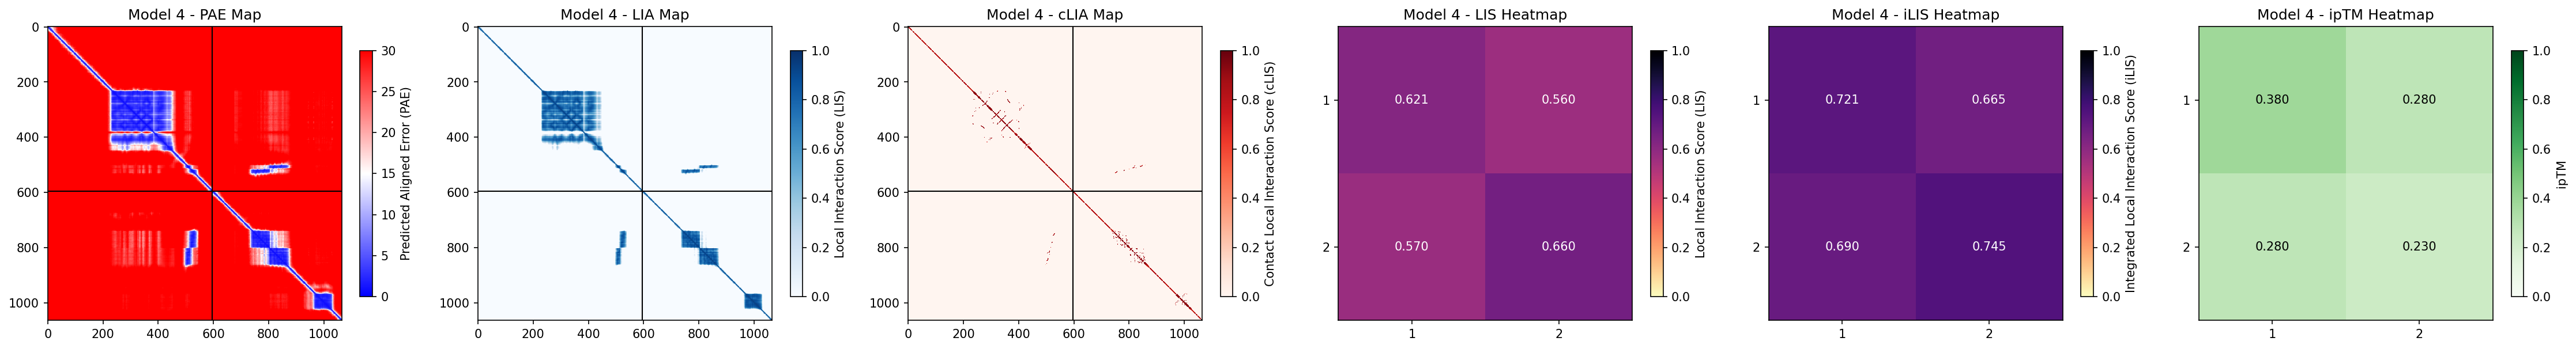

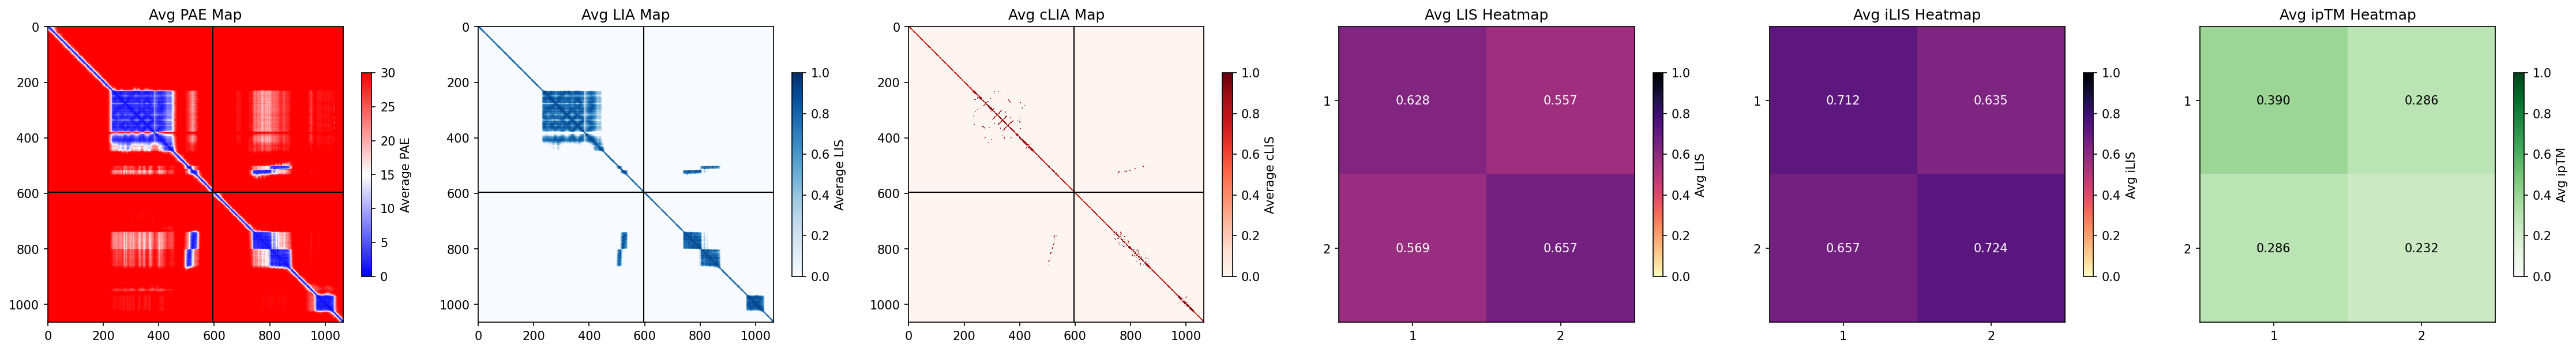

Results saved to: /content/alphafold3/fold_chi_ap_afm3/fold_chi_ap_afm3_lis_analysis.csv
fold_chi_ap_afm3_lis_analysis.csv
Processed: /content/alphafold3/fold_chi_ap_afm3
         folder_name model_number  protein_1  protein_2      iLIS       LIS  \
0   fold_chi_ap_afm3            0          1          1  0.724294  0.627157   
1   fold_chi_ap_afm3            0          1          2  0.673550  0.565972   
2   fold_chi_ap_afm3            0          2          2  0.741020  0.657274   
3   fold_chi_ap_afm3            1          1          1  0.725296  0.628261   
4   fold_chi_ap_afm3            1          1          2  0.671709  0.558527   
5   fold_chi_ap_afm3            1          2          2  0.739035  0.651733   
6   fold_chi_ap_afm3            2          1          1  0.726864  0.629913   
7   fold_chi_ap_afm3            2          1          2  0.670960  0.561554   
8   fold_chi_ap_afm3            2          2          2  0.742678  0.654453   
9   fold_chi_ap_afm3            3      

In [4]:
#@title Plotting LIS results and saving LIS output

mpl.rcParams['figure.dpi'] = 150 # change this for high resolution output
pae_cutoff = 12  # Adjust based on your preference
distance_cutoff = 8  # Can be too short or too long, adjust based on your preference
result_save = "True"  # If you want to save the results to a CSV file, set this to "True". Otherwise, set this to "False"

# Assuming generate_json_paths and afm3_plot are already defined
if base_path:
    # Process each subdirectory
    json_files = generate_json_paths(base_path, number_of_models=5)
    for json_file in json_files:
        afm3_plot(json_file, pae_cutoff, distance_cutoff)  # Plotting individual models
    afm3_plot_average(json_files, pae_cutoff, distance_cutoff)  # Plotting average of all models
    df_interactions = afm3_plot_average_to_df(json_files, pae_cutoff, distance_cutoff, result_save)
    print(f"Processed: {base_path}")
    print(df_interactions)
else:
    print("No zip file was uploaded and extracted.")
